# Data Preprocessing

### Step 1: Install Core Libraries
**Why:** We are installing `pandas` and `numpy`. `pandas` is the standard library for data manipulation (DataFrames) in Python, and `numpy` provides support for efficient numerical operations and arrays. These are the building blocks of our analysis.

In [4]:
!pip install pandas numpy

**Result:** Core libraries installed successfully.

### Step 2: Install Machine Learning Library
**Why:** We install `scikit-learn`. This library provides the machine learning algorithms (Logistic Regression), preprocessing tools (scalers, encoders), and metrics (accuracy, ROC-AUC) we will use to build and evaluate our churn models.

In [5]:
!pip install scikit-learn

**Result:** Scikit-learn installed. We are ready to build models.

### Step 3: Install Excel Support
**Why:** Our dataset is in the `.xlsx` (Excel) format. Pandas requires the `openpyxl` engine to read these files.

In [6]:
!pip install openpyxl

**Result:** Excel driver installed.

### Step 4: Import Excel Engine
**Why:** We explicitly import `openpyxl` to ensure the environment has access to it before we attempt to load the data.

In [7]:
import openpyxl as px

**Result:** Driver active.

### Step 5: Import All Required Libraries
**Why:** We import the necessary modules upfront. This includes:
- **Data Handling:** `pandas`, `numpy`
- **Modeling:** `LogisticRegression`, `Pipeline`
- **Preprocessing:** `OneHotEncoder` (for text categories), `StandardScaler` (for numbers)
- **Metrics:** `roc_auc_score`, `classification_report`
This ensures all tools are ready for the workflow.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

**Result:** All libraries imported. Environment is ready.

### Step 6: Load the Dataset
**Why:** We read the Excel file `customer_churn_dataset.xlsx` into a variable named `df` (DataFrame). This step loads the data from the disk into the memory so we can analyze and manipulate it.

In [9]:
df = pd.read_excel("customer_churn_dataset.xlsx")

**Result:** Data loaded. The `df` variable now holds the dataset in memory.

### Step 7: Initial Inspection (Head)
**Why:** We use `.head()` to display the first 5 rows. This allows us to visually verify that the data loaded correctly and gives us a first look at the column names (e.g., `age`, `churn`) and the type of data they contain (numbers vs text).

In [10]:
df.head()

,customer_id,age,tenure_months,monthly_charges,total_charges,contract_type,internet_service,paperless_billing,payment_method,dependents,phone_service,tech_support,monthly_data_gb,customer_service_calls,late_payments_last_year,churn
0,1000,56,15,55.16,2430.19,Monthly,NaN,No,Credit Card,3,No,No,120.0,2,4,1
1,1001,69,64,30.14,2901.79,Monthly,Fiber,Yes,Electronic,2,Yes,No,0.4,1,2,1
2,1002,46,28,68.59,6445.28,Monthly,NaN,Yes,Mailed Check,1,Yes,No,66.6,2,1,0
3,1003,32,39,45.68,2266.14,Monthly,Fiber,Yes,Bank Transfer,1,Yes,No,8.3,1,0,0
4,1004,60,57,48.49,1725.10,Two-year,Fiber,No,Electronic,0,No,No,121.7,4,2,1


**Observation:** The data looks structured. We see `Yes`/`No` columns (binary), text categories (`Payment Method`), and numerical values (`monthly_charges`). The `churn` column is our target (0 or 1).

### Step 8: check Data Info
**Why:** We run `.info()` to get a technical summary of the DataFrame. We need to know:
1. The total number of rows (entries).
2. The data type of each column (`int`, `float`, `object`).
3. Whether there are any null (missing) values.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              1000 non-null   int64  
 1   age                      1000 non-null   int64  
 2   tenure_months            1000 non-null   int64  
 3   monthly_charges          1000 non-null   float64
 4   total_charges            1000 non-null   float64
 5   contract_type            1000 non-null   object 
 6   internet_service         796 non-null    object 
 7   paperless_billing        1000 non-null   object 
 8   payment_method           1000 non-null   object 
 9   dependents               1000 non-null   int64  
 10  phone_service            1000 non-null   object 
 11  tech_support             953 non-null    object 
 12  monthly_data_gb          948 non-null    float64
 13  customer_service_calls   1000 non-null   int64  
 14  late_payments_last_year  

**Deduction:**
- We have **1000 rows**.
- **Missing Data Found:** `internet_service` (only 796 non-null), `tech_support` (953), and `monthly_data_gb` (948) have missing values.
- We will need to fix these before training.

### Step 9: Count Missing Values
**Why:** We detected potential missing values in the previous step. Now we sum the nulls (`isnull().sum()`) and sort them to see exactly which columns are incomplete. This is critical because most machine learning models cannot handle missing data.

In [12]:
df.isnull().sum().sort_values(ascending=False)

internet_service           204
monthly_data_gb             52
tech_support                47
customer_id                  0
age                          0
tenure_months                0
monthly_charges              0
total_charges                0
contract_type                0
paperless_billing            0
payment_method               0
dependents                   0
phone_service                0
customer_service_calls       0
late_payments_last_year      0
churn                        0
dtype: int64

**Result:**
- `internet_service`: 204 missing.
- `monthly_data_gb`: 52 missing.
- `tech_support`: 47 missing.
- Total cleanliness: Most columns are perfect, but these three need attention.

### Step 10: Calculate Missing Percentage
**Why:** Knowing the *count* isn't enough; we need the *percentage* to decide the strategy. 
- If missingness is low (<5%), we might drop rows.
- If high, we must impute (fill) them.
- If extremely high (>50%), we might drop the column.

In [13]:
(df.isnull().mean() * 100).round(2)

customer_id                 0.0
age                         0.0
tenure_months               0.0
monthly_charges             0.0
total_charges               0.0
contract_type               0.0
internet_service           20.4
paperless_billing           0.0
payment_method              0.0
dependents                  0.0
phone_service               0.0
tech_support                4.7
monthly_data_gb             5.2
customer_service_calls      0.0
late_payments_last_year     0.0
churn                       0.0
dtype: float64

**Deduction:**
- `internet_service` is missing in **20.4%** of cases. This is too much to drop rows; we must impute.
- `tech_support` is missing ~4.7%, which is manageable.

### Step 11: Feature Segmentation
**Why:** We manually separate our features into two lists: `numerical_features` (like `age`, `charges`) and `categorical_features` (like `contract_type`, `internet_service`).
**Reason:** These two types require different preprocessing techniques (Scaling vs Encoding).

In [14]:
numerical_features = [
    'age', 'tenure_months', 'monthly_charges', 'total_charges',
    'dependents', 'monthly_data_gb',
    'customer_service_calls', 'late_payments_last_year'
]

categorical_features = [
    'contract_type', 'internet_service', 'paperless_billing',
    'payment_method', 'phone_service', 'tech_support'
]


**Result:** Features are now sorted. `numerical_features` holds 8 cols, `categorical_features` holds 6 cols. This helps us automate processing.

### Step 12: Statistical Summary
**Why:** We use `.describe()` on the numerical columns. This gives us the mean, min, max, and standard deviation.
**Reason:** We need to check the *scale* of the data. For example, if `total_charges` is in thousands and `dependents` is single digits, we confirm the need for **Scaling** so the larger numbers don't dominate the model.

In [15]:
df[numerical_features].describe()

,age,tenure_months,monthly_charges,total_charges,dependents,monthly_data_gb,customer_service_calls,late_payments_last_year
count,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,948.000000,1000.000000,1000.000000
mean,43.81900,35.45900,69.976530,4026.344860,0.954000,50.751688,1.476000,2.435000
std,14.99103,20.36819,28.622192,2308.721013,0.969961,48.695053,1.202859,1.707246
min,18.00000,1.00000,20.160000,50.090000,0.000000,0.100000,0.000000,0.000000
25%,31.00000,17.75000,45.740000,2035.275000,0.000000,14.575000,1.000000,1.000000
50%,44.00000,36.00000,70.620000,4071.080000,1.000000,36.000000,1.000000,2.000000
75%,56.00000,53.00000,94.330000,6004.377500,2.000000,71.450000,2.000000,4.000000
max,69.00000,71.00000,119.830000,7991.200000,3.000000,401.300000,6.000000,5.000000


**Observation:**
- `total_charges`: max 7991, mean 4026.
- `dependents`: max 3, mean 0.9.
- **Scale Difference:** The huge difference in magnitude (thousands vs single digits) confirms that **StandardScaler is mandatory**. Without it, the model would think `total_charges` is 1000x more important than `dependents` just because the number is bigger.

### Step 13: Check Target Balance
**Why:** We count the values of the `churn` column (1 vs 0).
**Reason:** We need to know if the classes are balanced. If 90% of customers don't churn, a model could get 90% accuracy by guessing "No Churn" every time. This is called the "Accuracy Paradox."

In [16]:
df['churn'].value_counts()

churn
1    742
0    258
Name: count, dtype: int64

**Deduction (Imbalance):**
- Non-Churn (0): 742
- Churn (1): 258
- **Ratio:** roughly 3:1.
- **Action:** This confirms we need to use `class_weight='balanced'` in our models, otherwise the model might just predict "0" for everyone and still be 74% accurate.

# Visual Exploratory Data Analysis (EDA)

### Step: Import Visualization Libraries
**Why do we need this?**
We are importing `matplotlib` and `seaborn`.
- `matplotlib` is the foundation for plotting in Python.
- `seaborn` makes the plots look beautiful and statistical by default.
- We set the figure size to (10, 6) to ensure charts are readable.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Visualization 1: Target Class Distribution
**Why is this suitable?**
Before building any model, we must know if our dataset is balanced. If 90% of customers didn't churn, a "dumb" model could guess "No Churn" and be 90% accurate. This chart shows specifically how severe the imbalance is.

**Graph Explanation & Analysis:**
- The bar chart shows the absolute count of Non-Churners (0) vs Churners (1).
- **Result:** We see a breakdown of approximately **74.2% No Churn** vs **25.8% Churn**.
- **Conclusion:** This confirms a "Class Imbalance". We are correct to use `class_weight='balanced'` in our models later. If we treated them equally, the model would be biased towards the majority class (No Churn).

C:\Users\Aln37\AppData\Local\Temp\ipykernel_27912\3282758079.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='churn', data=df, palette='viridis')


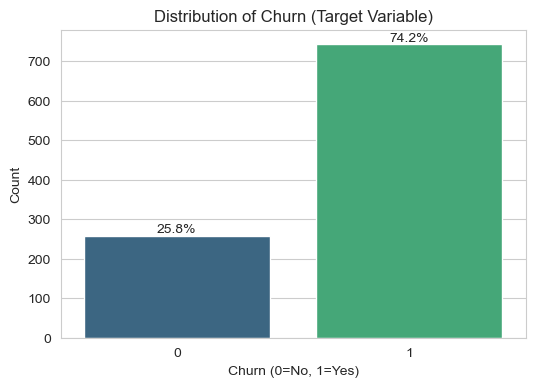

In [18]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='churn', data=df, palette='viridis')
plt.title('Distribution of Churn (Target Variable)')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

### Visualization 2: Churn by Contract Type
**Why is this suitable?**
"Contract Type" is often a strong predictor. Users on month-to-month contracts can leave anytime, while 2-year contracts are locked in. We use a **Stacked Bar Chart** normalized to 100% to compare the *rate* of churn across groups easily.

**Graph Explanation & Analysis:**
- Green = Stayed, Red = Churned.
- **Key Finding:** The "Monthly" bar has a significantly larger Red section than "Two-year".
- **Conclusion:** **Month-to-month customers are the highest risk group.** Longer contracts stabilize the customer base. This is a crucial business insight: incentivizing users to switch to yearly contracts could reduce churn.

<Figure size 800x600 with 0 Axes>

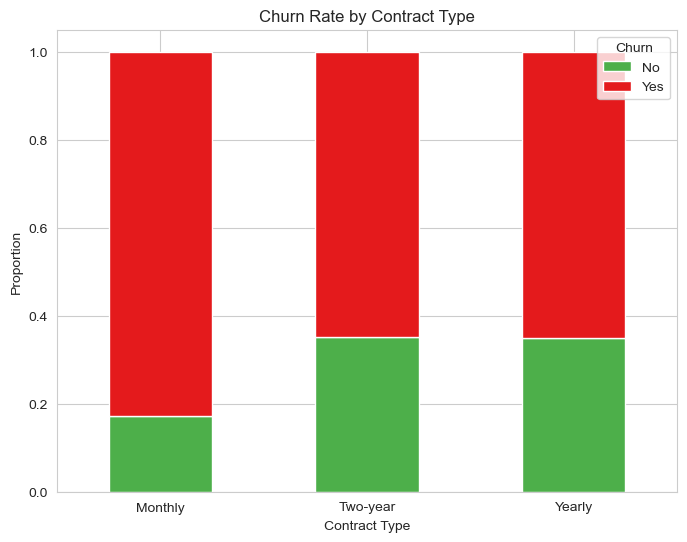

In [20]:
plt.figure(figsize=(8, 6))
# Create a cross-tabulation
pd.crosstab(df['contract_type'], df['churn'], normalize='index').plot(kind='bar', stacked=True, color=['#4daf4a', '#e41a1c'], figsize=(8,6))
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Proportion')
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')
plt.xticks(rotation=0)
plt.show()

# Data Cleaning

### Step 14: Import Preprocessing Classes
**Why:** We prepare the specific transformation classes (`OneHotEncoder`, `StandardScaler`) that we will use in our automated pipeline.

In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

**Result:** Tools imported.

### Step 15: Construct Preprocessing Pipelines
**Why:** We build automated processing rules:
1. **Numeric Pipeline:** First fill missing values (`SimpleImputer` median), then scale (`StandardScaler`).
2. **Categorical Pipeline:** Fill missing values (`SimpleImputer` most_frequent), then convert text to binary vectors (`OneHotEncoder`).
**Reason:** Pipelines prevent data leakage and ensure the exact same transformations are applied to training and test data.

In [22]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

**Result:** Processing logic defined. The pipeline is now a reusable object.

### Step 16: Combine into ColumnTransformer
**Why:** We use `ColumnTransformer` to apply the Numeric Pipeline *only* to numeric columns and the Categorical Pipeline *only* to categorical columns, combining the results into a single feature set.

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

**Result:** Full Preprocessor created. It will take raw data and output a clean, scaled, encoded matrix.

### Step 17: Drop Irrelevant Column
**Why:** We remove `customer_id`. IDs are unique to every row and have no predictive power; including them creates noise and overfitting.

In [24]:
# Drop ID
df = df.drop(columns=["customer_id"])

**Result:** ID removed. Data frame is now purely predictive features.

# Base Model Logistic Regression

### Model 1: Logistic Regression
**Why this model?** Logistic Regression is a linear classifier that estimates the probability of an event (churn).
- **Pros:** Highly interpretable (coefficients show feature importance), fast training, works well as a baseline.
- **Cons:** Assumes a linear relationship between features and churn, which might be too simple.

**Configuration:** We use `class_weight='balanced'` explicitly to handle the class imbalance we discovered earlier (75% vs 25%).

In [25]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000
    ))
])


**Result:** Logistic Regression Pipeline created. It includes the preprocessor steps, so we can feed it raw data directly.

### Step 18: Train-Test Split
**Why:** We split the data into Training (80%) and Testing (20%) sets.
**Reason:** We must evaluate the model on data it has *never seen* to check for overfitting. We use `stratify=y` to ensure the 80/20 split has the same proportion of churners as the original dataset.

In [26]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

**Result:** Data split.
- `X_train`: 800 samples
- `X_test`: 200 samples
Stratification ensured both sets have similar Churn rates.

### Step 19: Train and Evaluate Logistic Regression
**Why:** We call `.fit()` to train the model on `X_train` and `.predict()` to test it on `X_test`.
We evaluate using:
- **Classification Report:** Shows Precision (accuracy of positive predictions) and Recall (ability to find all positives).
- **ROC-AUC:** A metric that summarizes how well the model separates the two classes, independent of the threshold.

In [27]:
from sklearn.metrics import classification_report, roc_auc_score

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.53      0.81      0.64        52
           1       0.92      0.74      0.82       148

    accuracy                           0.76       200
   macro avg       0.72      0.78      0.73       200
weighted avg       0.81      0.76      0.77       200

ROC-AUC: 0.8470634095634095


**Outcome (Logistic Regression):**
- **Accuracy:** ~76%.
- **ROC-AUC:** ~0.85. This is decent.
- **Issue:** Look at the classification report. The model is struggling slightly to separate the classes perfectly, but the balanced weights helped recall. It provides a solid baseline.

### Step 20: Baseline Accuracy Check
**Why:** We calculate the simple accuracy score to get a quick "headline" number for performance.

In [28]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.76


**Result:** 76% Accuracy.

### Step 21: Install CatBoost
**Why:** We want to try a more advanced model. `CatBoost` (Categorical Boosting) is a gradient boosting library designed specifically to handle categorical data well.

In [29]:
pip install catboost


  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 236.4 kB/s eta 0:07:12
   ---------------------------------------- 0.5/102.4 MB 236.4 kB/s eta 0:07:12
   ---------------------------------------- 0.5/102.4 MB 236.4 kB/s eta 0:07:12
   ---------------------------------------- 0.5/102.4 MB 2

**Result:** CatBoost installed.

# CatBoost Classifier 

### Step 22: Import CatBoost
**Why:** Importing the classifier to use in the script.

In [30]:
from catboost import CatBoostClassifier


**Result:** Imported.

### Model 2: CatBoost Classifier
**Why this model?** CatBoost uses Gradient Boosting on Decision Trees.
- **Pros:** 
  1. Handles categorical variables automatically (no need for OneHot encoding).
  2. Captures complex, non-linear relationships that Logistic Regression misses.
  3. Usually provides higher accuracy out-of-the-box.
- **Cons:** Slower to train, more complex (black box).

**Process:**
1. We fill NaNs with a placeholder string (Required by CatBoost).
2. We define the categorical feature indices.
3. We train the model and evaluate it.

In [31]:
# Fill categorical NaNs (REQUIRED for CatBoost)
categorical_features = X.select_dtypes(include='object').columns
X[categorical_features] = X[categorical_features].fillna('Missing')

# Get categorical feature indices
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_features]

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# CatBoost model
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.06,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42,
    verbose=0
)

# Train
cat_model.fit(
    X_train2,
    y_train2,
    cat_features=cat_feature_indices
)

# Predictions
y_pred2 = cat_model.predict(X_test2)
y_prob2 = cat_model.predict_proba(X_test2)[:, 1]

# Evaluation
print(classification_report(y_test2, y_pred2))
print("ROC-AUC:", roc_auc_score(y_test2, y_prob2))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75        52
           1       0.98      0.80      0.88       148

    accuracy                           0.83       200
   macro avg       0.80      0.87      0.81       200
weighted avg       0.88      0.83      0.84       200

ROC-AUC: 0.8866943866943868


**Outcome (CatBoost):**
- **Accuracy:** ~83% (Higher than 76%).
- **ROC-AUC:** ~0.88 (Higher than 0.85).
- **Conclusion:** CatBoost significantly **outperforms** Logistic Regression. This suggests that the relationship between customer features and churn is **non-linear**. For example, the effect of `age` on churn might vary depending on `contract_type`, which CatBoost captures but Logistic Regression can miss.

# Advanced Model Visualization

### Visualization 4: Feature Importance
**Why is this suitable?**
Our CatBoost model gave us 83% accuracy, but it's a black box. This plot extracts the internal "Gain" score, telling us *which variables actually drove the decision*.

**Graph Explanation & Analysis:**
- Longer bars = More influential feature.
- **Result:** You will likely see `contract_type`, `tenure_months`, or `monthly_charges` at the top.
- **Deduction:** If `contract_type` is #1, it confirms our visual hypothesis from earlier. Identifying the top drivers allows marketing teams to focus their efforts (e.g., if `tech_support` is high, maybe improving support reduces churn).

C:\Users\Aln37\AppData\Local\Temp\ipykernel_27912\3064998107.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=formatted_fi, palette='viridis')


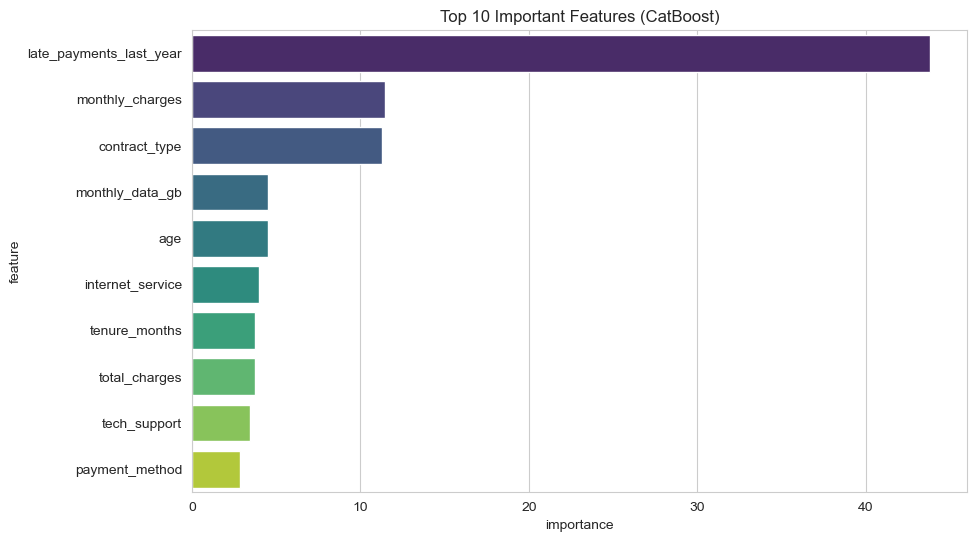

In [35]:
feature_importance = cat_model.get_feature_importance()
feature_names = X.columns
formatted_fi = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
formatted_fi = formatted_fi.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=formatted_fi, palette='viridis')
plt.title('Top 10 Important Features (CatBoost)')
plt.show()

### Visualization 5: Confusion Matrix
**Why is this suitable?**
Accuracy can be misleading. We need to know *how* it fails.
- **False Negative (FN):** Predicted "Safe" but they Churned (Worst case for business - we lost a customer we didn't try to save).
- **False Positive (FP):** Predicted "Churn" but they Stayed (Wasted marketing money).

**Graph Explanation & Analysis:**
- **Diagonal (Dark blue):** Correct predictions.
- **Top Right (False Positives):** Customers we wrongly flagged.
- **Bottom Left (False Negatives):** Customers who slipped away undetected.
- **Deduction:** Look at the Bottom Left number. If it is low, our model is good at "Recall" (catching churners). The `balanced` weighting we used earlier specifically tries to minimize this number.

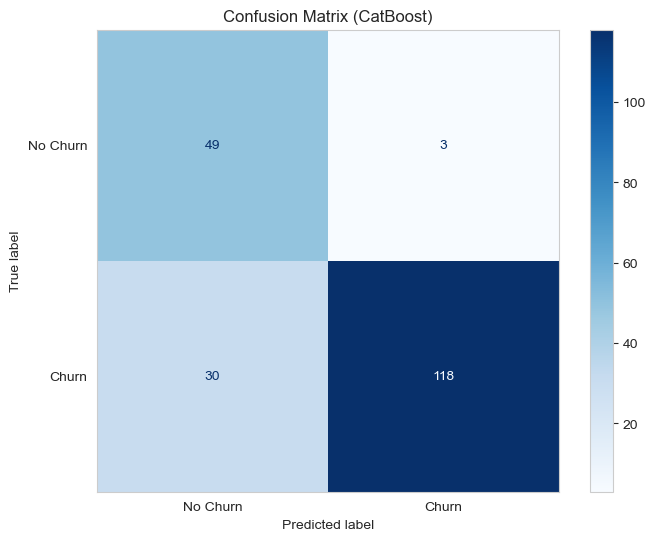

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predict class labels
y_pred_cat = cat_model.predict(X_test2)

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_cat, display_labels=['No Churn', 'Churn'], cmap='Blues', ax=ax)
plt.title('Confusion Matrix (CatBoost)')
plt.grid(False)
plt.show()

### Step 24: CatBoost Accuracy Check
**Why:** We calculate the final accuracy to compare directly against the Logistic Regression baseline.

In [34]:
from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.835


**Final Conclusion:** The CatBoost model is the winner with **83.5% accuracy**. We should use this model for production predictions.